# Hierarchical Clustering

## Description

I made this notebook with the purpose of training.
This dataset is composed of 3360 samples with 7 features each. It does not come from a real setting. The first column
represents the sample id. The remaining columns are features. There are no
categorical features.

My objective is the following: I should find an optimal clustering of the data
using Hierarchical Clustering (implemented by
sklearn.cluster.AgglomerativeClustering). This includes finding the best number
of clusters. I will need to decide whether or not to scale the data, whether or not to perform
PCA, and in which order to perform these operations, as well as finding the optimal parameters for
the algorithm etc.

## Intro

We're dealing with an unsupervised Machine Learning Problem. More specifically, we will apply an Agglomerative Clustering algorithm, which is a type of Hierarchicals.
After having imported the libraries and the dataset we perform some data visualisation and feature engineering. Then, data will be scaled and a Principal Component Analysis will be performed. Then the algorithm will be run and finally some graphical representations follow.

## Exploratory Data Analysis

### Libraries import

In [1]:
#Libraries to work with Data 
import pandas as pd
import numpy as np

# Libraries for Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D


#Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Principal Component Analysis
from sklearn.decomposition import PCA

#Clustering
from sklearn.cluster import AgglomerativeClustering

#Evaluation
from sklearn import metrics


pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

### Data loading

In [2]:
data=pd.read_csv("mldata.csv") #Loading the database

### Data Structure

First of all, let's have an initial look at the database if there is something interesting to notice.

In [3]:
data.head() #Command to show the first 5 instances of the database

,Unnamed: 0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
0,0,0.322526,2.074099,0.547828,0.851104,-0.011236,2.096270,0.937596
1,1,0.685249,3.059133,0.345994,-0.333504,0.759613,1.792180,0.465014
2,2,0.279948,2.536662,0.192510,0.631764,0.232433,1.052200,1.412000
3,3,0.355961,0.288815,1.614999,3.822119,0.364060,3.258248,0.558122
4,4,0.330523,0.242614,1.498254,3.810394,0.366973,3.161501,0.589917


We immediately note that the ID column is not necessary because it does not give any information about the instances, so we drop the entire column.

In [4]:
sample_id = data['Unnamed: 0'] #Saving the IDs just in case
data.drop("Unnamed: 0", axis=1, inplace=True)

We now have a look at some useful information about the features.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 7 columns):
feature_1    3360 non-null float64
feature_2    3360 non-null float64
feature_3    3360 non-null float64
feature_4    3360 non-null float64
feature_5    3360 non-null float64
feature_6    3360 non-null float64
feature_7    3360 non-null float64
dtypes: float64(7)
memory usage: 183.9 KB


As we expected, we note that the instances are __3360__ and there are __no missing values__. All the variables take `float` values.

Let's show some descriptive statistics to get a deeper understanding of the database.

In [6]:
data.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
count,3360.000000,3360.000000,3360.000000,3360.000000,3360.000000,3360.000000,3360.000000
mean,0.445752,1.677849,0.714765,1.515155,0.333435,2.536411,0.770223
std,0.336456,1.241983,0.564190,1.334971,0.247950,1.439548,0.392998
min,-0.487017,-0.563507,-0.470319,-1.240898,-0.120355,-0.691665,-0.328084
25%,0.233624,0.410296,0.210063,0.426325,0.124707,1.528645,0.536166
50%,0.323862,1.852546,0.584530,1.004901,0.317549,2.174818,0.801313
75%,0.798382,2.755832,1.283192,2.971225,0.419774,3.688498,1.052151
max,1.137361,4.333224,1.788001,4.139519,1.016432,6.424992,2.095016


### Data visualisation: features distribution histograms

Let's now look at the distribution of each feature through histograms. They will provide us insights about the most represented values, but will also allow us to understand if some feature scaling is needed.

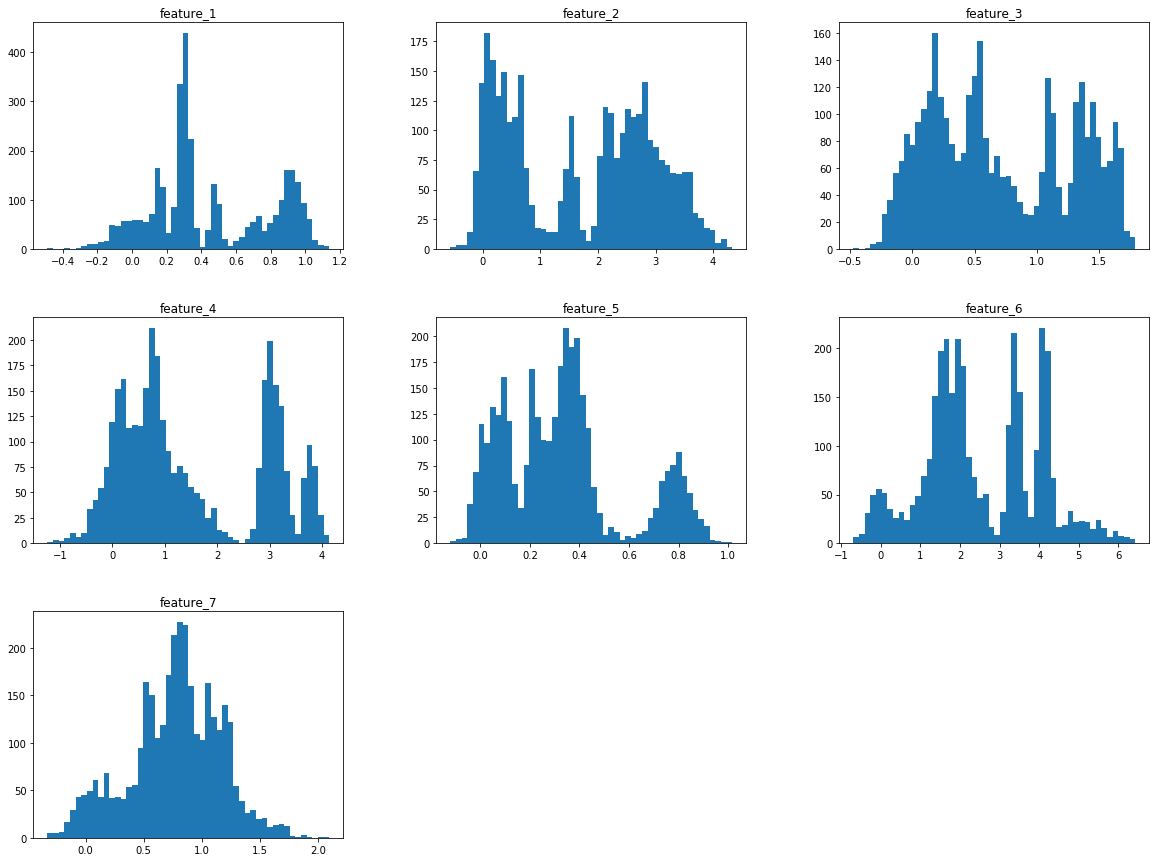

In [7]:
histogram=data.hist(bins=50, figsize=(20,15), grid=False)

We will have to scale the data since some features have different ranges of values, and it will also allow the clustering algorithm to work better. Since the distribution of most of the features is quite far to be Normal a Standard Scaler is not the best choice. Minmax scaling should be fine in this scenario, but to be sure both scaling methods will be implemented and compared.

### Exploring features' correlation

Before heading to the scaling and the proper analysis we now check the correlation coefficients betweeen the features. To do so, we compute and plot the correlation matrix. From the correlation matrix we can check whether some variables are highly correlated. High collinearity may be addressed with dimensionality reduction (PCA) or by dropping the redundant features.

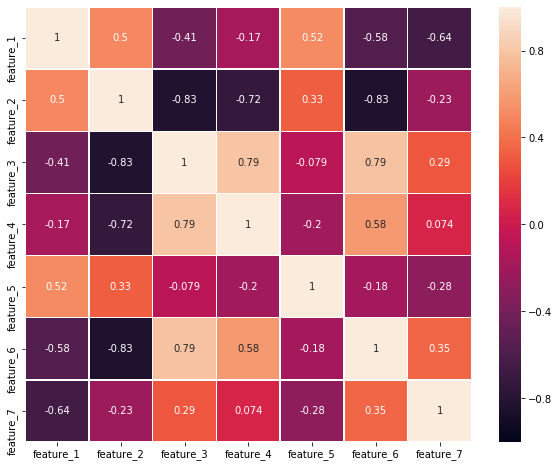

In [8]:
#Correlation Matrix Heatmap
corr = data.corr()
plt.figure(figsize=(10,8))
ax=sns.heatmap(corr, xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values, 
            vmin=-1, vmax=1, linewidths=.5, annot=True)

bottom, top = ax.get_ylim() #Little workaround for a bug of Matplotlib which cuts off the matrix
lim=ax.set_ylim(bottom + 0.5, top - 0.5)


As can be seen from the matrix, the feature 2 is higly negatively correlated with feature 6, 3 and 4. Still, I decided not to drop the feature since a correlated feature should not deteriorate the agglomerative clustering algirithm, but just increase the computations. Nevertheless, PCA could turn out to be useful.

## Preparatory data manipulation

We now implement the two different methods for scaling, compare them and choose one of them. Then, a Principal Component Analysis is performed.

### Scaling

In [9]:
#Scaling the features with MinMaxScaler
cols=data.columns # Here I save up the columns names to re-insert them in the scaled dataset

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)
data_sc_minmax = scaler.transform(data)
data_sc_minmax = pd.DataFrame(data_sc_minmax, columns=cols)

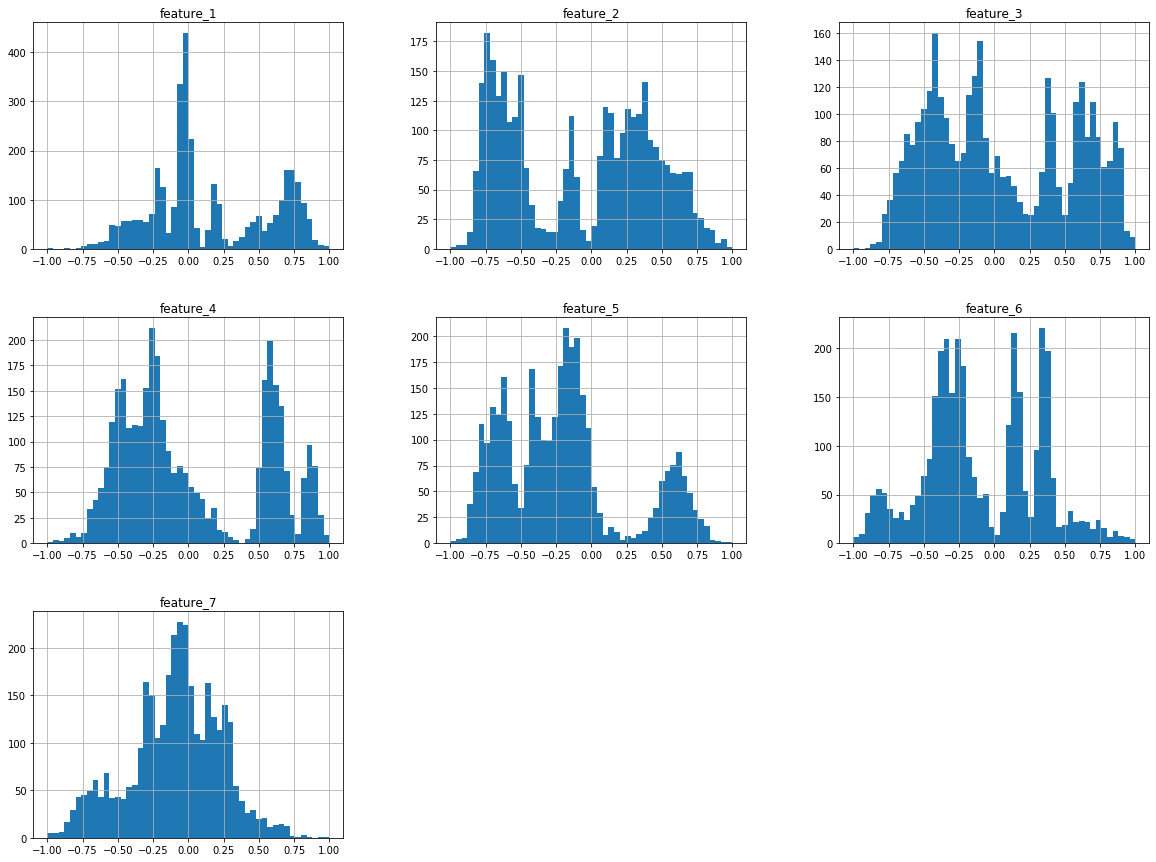

In [10]:
histogram=data_sc_minmax.hist(bins=50, figsize=(20,15), grid=True)

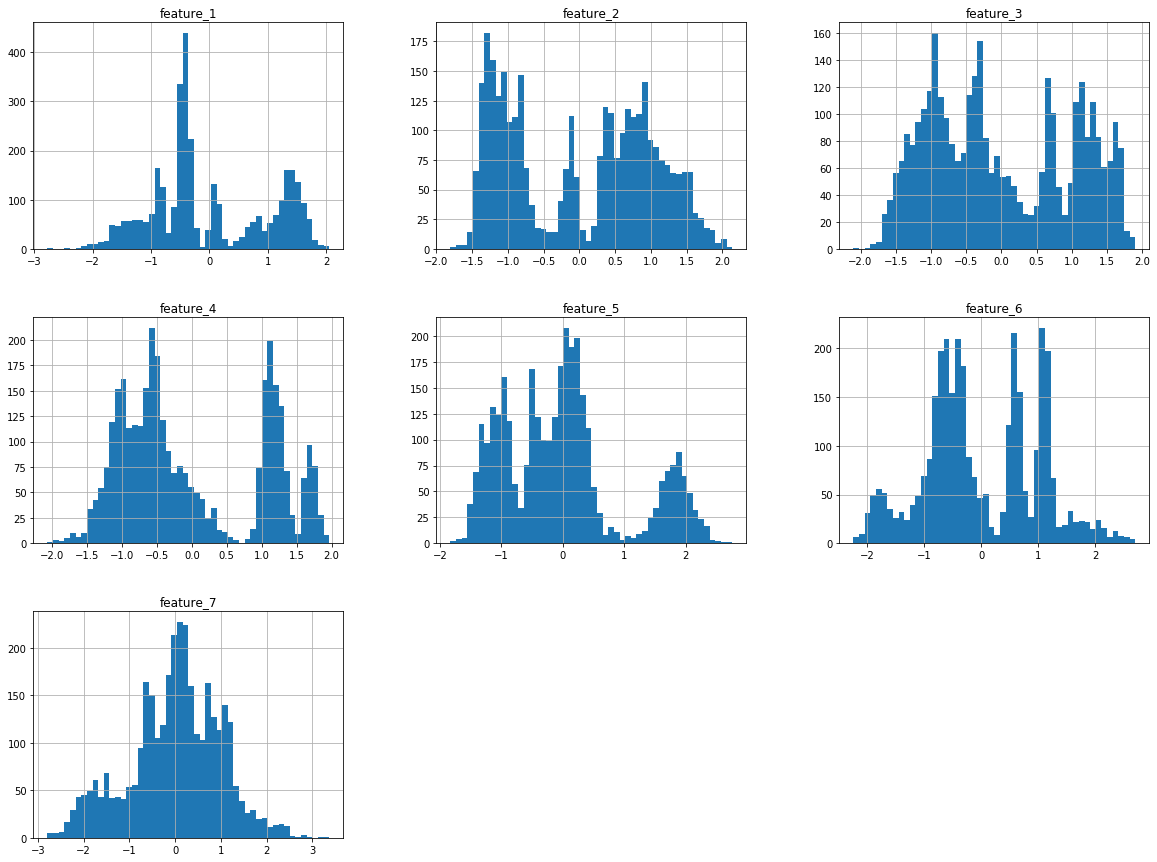

In [11]:
#Scaling the features with StandardScaler
scaler = StandardScaler()
scaler.fit(data)
data_sc_std = scaler.transform(data)
data_sc_std = pd.DataFrame(data_sc_std, columns=cols)
histogram=data_sc_std.hist(bins=50, figsize=(20,15), grid=True)

The results of the two scaling methodologies are quite similar, but we're going to stick with Minmax Scaling, because of the non-Normal distribution of some of the features and the more manageable value range of (-1,+1)

In [12]:
data_sc = data_sc_minmax

### Principal component analysis

PCA is useful to identify the directions of the data that carry maximum variance and hence reduce the components of the database according to the quantity of variance that you want to keep.

#### Cumulative variance explained

Firstly, we will dig deeper to see if PCA can be really useful in this case. To do so, we will plot the line of the cumulative variance explained when the number of principal components varies, so we can choose the number of  components as to explain the 95% of the variance. We will do so both with the scaled and non-scaled data for comparison.

In [13]:
data_list=[data, data_sc]
names=["Non scaled data", "Scaled Data"]
cumsum=[]
num_comp=[]
pca = PCA()
for i in range(2):
    pca.fit(data_list[i]) #Calculate Eigenvalues
    variance = pca.explained_variance_ratio_ #Variance ratios
    cumsum.append(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)) #cumulative sum of variance explained
    num_comp.append(np.argmax(cumsum[i] >= 95.0)+1) #d is the number of components we want to keep to explain at least the 95 percent of the variance
    print(names[i])
    print("Explained variances:", cumsum[i], "\n","Number of components chosen:", num_comp[i], "\n") 
num_comp_non_sc, num_comp_sc = num_comp

Non scaled data
Explained variances: [76.9 90.9 94.9 97.7 99.  99.6 99.9] 
 Number of components chosen: 4 

Scaled Data
Explained variances: [ 59.9  78.8  89.1  94.3  96.6  98.5 100.1] 
 Number of components chosen: 5 



In [14]:
#I also use the built-in method as a doublecheck
pca = PCA(n_components = 0.95) #Putting a value less than one for n_components parameter it automatically
#makes it such that such portion of the variance is preserved.
pca.fit(data_sc) 
cumsum_2=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
num_comp_2=np.argmax(cumsum_2 >= 95.0)+1
print("The number of components to keep the 95% of the variance (with scaled data) is:", num_comp_2)

The number of components to keep the 95% of the variance (with scaled data) is: 5


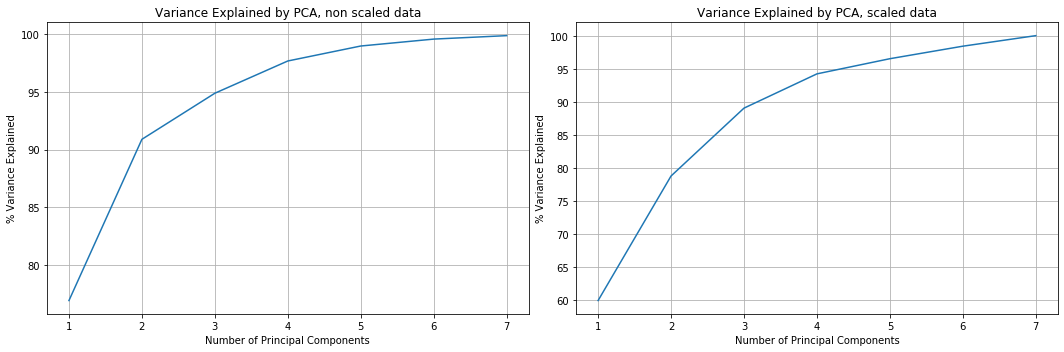

In [15]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
num_components=np.arange(1,data.shape[1]+1)


ax1.set_ylabel('% Variance Explained')
ax1.set_xlabel('Number of Principal Components')
ax1.set_title('Variance Explained by PCA, non scaled data')
ax1.grid()
num_components_sc=np.arange(1,data_sc.shape[1]+1)
plt1=ax1.plot(num_components_sc,cumsum[0])


ax2.set_ylabel('% Variance Explained')
ax2.set_xlabel('Number of Principal Components')
ax2.set_title('Variance Explained by PCA, scaled data')
ax2.grid()

plt.tight_layout()

plt2=ax2.plot(num_components,cumsum[1])


As can easily be seen by the cumulative variance explained graph, with non-scaled data 4 components are sufficient to explain more than 95% of the total variance, whereas with scaled data 5 components are needed.

#### PCA

Since we will stick with scaled data, as long as the project and clustering are concerned, the number of components we will use for PCA is 5, as shown above. Nevertheless, just for the matter of visualisation we will now perform a PCA with 2 and 3 components to both scaled and non scaled data. This way we can plot in 2D and 3D graphs, respectively, the data onto the 2 and 3 principal components.


Graph of PCA-reduced features with non-scaled data



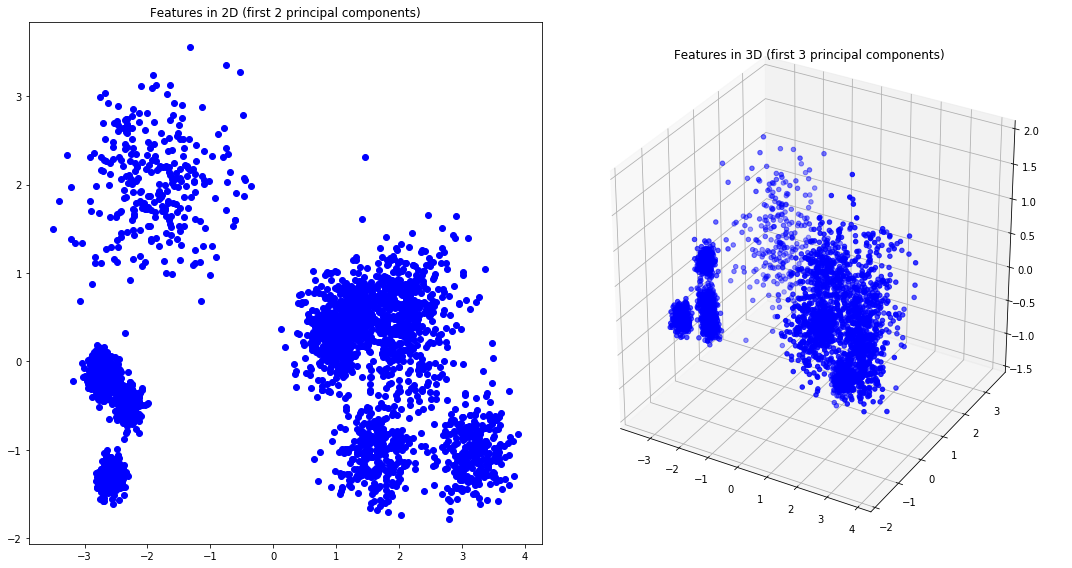


Graph of PCA-reduced features with scaled data (MinMax)



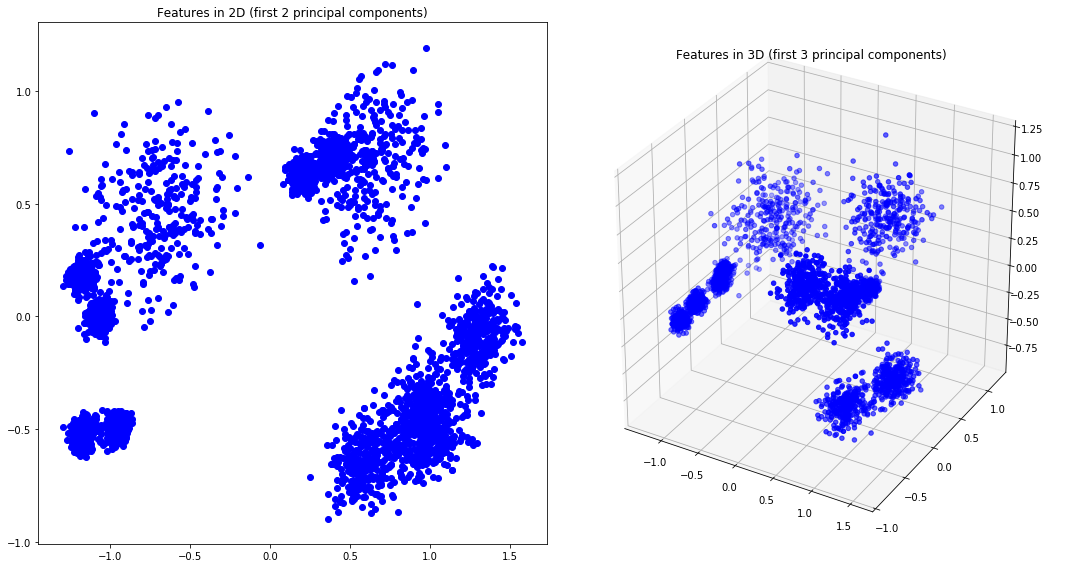

In [16]:
non_scaled = PCA(n_components=3).fit_transform(data)
scaled = PCA(n_components=3).fit_transform(data_sc)
data_after_PCA = [non_scaled, scaled]
titles = ['\nGraph of PCA-reduced features with non-scaled data\n', '\nGraph of PCA-reduced features with scaled data (MinMax)\n']

for i in range(2):
    reduced_data = data_after_PCA[i]
    title = titles[i]
    fig = plt.figure(figsize=(15,8))

    #PCA in 2D
    ax1 = fig.add_subplot(121) 
    ax1.scatter(reduced_data[:,0], reduced_data[:,1], linewidths=True, c='b')
    ax1.set_title('Features in 2D (first 2 principal components)')

    #PCA in 3D
    ax2 = fig.add_subplot(122, projection='3d')  

    ax2.scatter(reduced_data[:,0],reduced_data[:,1], reduced_data[:,2], c='b');
    ax2.set_title('Features in 3D (first 3 principal components)')
    
    print(title)
    plt.tight_layout()
    plt.show()
    


We can already notice some kind of similarities among groups of data, especially with scaled data.

In [17]:
#From now on, we'll use scaled, PCA-transformed (with num_comp_sc=5 components) data

scaled = PCA(n_components=num_comp_sc).fit_transform(data_sc)
new_data = scaled


## Clustering

Before applying the proper clustering algotithm we need to make some choices about the parameters. As long as agglomerative clustering is concerned, relevant parameters to be identified are: the number of clusters, the type of linkage and the affinity, which is the metric used to compute the linkage. To properly do so, in theory, we would need to fully understand and make sense of the data and have in mind what we're looking for, which is something that can't really be done with randomly generated data. We will try anyway to find the best values for the parameters.

As long as the metric is concerned, I decided to use the Euclidean Distance a priori. Since the data is numerical and scaled, the Euclidean works fine.

Let's now proceed to choosing the number of clusters and the linkage method. For the linkage method, before doing any computation, I'll be more inclined to choose the average one, since it's far less susceptible of outliers. Still, I will check the values of some metrics to verify that it actually provides a good clustering.

### Choosing the number of clusters and the linkage method

Let's now find a way to choose the number of clusters. We will use different methods and compare the results to check if there is a shared result. 
To understand what the optimal number of cluster is we will do a "manual" grid search, evaluating the Silhouette coefficient of the model, every time initialised with a different number of clusters. The Silhouette coefficient is one of the most common ways to evauate a model in Unsupervised Learning (in which, of course, the usual accuracy measures are not helpful). 

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is $$S_{s}=\frac{(b-a)}{max(a,b)}$$


As a doublecheck, we'll also compute the values of the Calinski Harabasz score (Variance Ratio criterion), which is defined as the ratio between the within-cluster dispersion and the between-cluster dispersion, where dispersion is defined as the sum of distances squared:

$$S_{ch}=\frac{SS_{B}}{SS_{W}}\times \frac{N-k}{k-1}$$

Where k is the number of clusters, N is the total number data points, $SS_{W}$ is the overall within-cluster variance, $SS_{B}$ is the overall between-cluster variance.

Finally, as an additional check we'll also look at the Davies Boulding Index, which is another frequently used  metric to evaluate clustering algorithms. It is defined as the average similarity measure of each cluster with its most similar cluster. In this settings, similarity is defined as within-cluster distances over between-cluster distances. Less dispersed clusters will result in a better score. Lower values indicate better clustering.


In [18]:
#I decided to create an "all-purpose" unique measuring function for the three metrics chosen.
#Measuring
#Silhouette Coefficient
#Calinski-Harabasz Index
#Davies-Bouldin Index

def compute_score(method="s", linkage="average", verbose=False, ret_list=False):
    #"s"  for Silhouette, "c" for Calinski harabasz, "d" for Davies Boulding
    list_scores=[]
    for k in range(2,21):
        #I'm trying 2 to 20 clusters, which is a significant range
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=k).fit_predict(new_data)
        if method=="s":
            #Silhouette score computation
            score_temp=metrics.silhouette_score(new_data, clustering, metric='euclidean')
            list_scores.append(score_temp)
            if verbose==True:
                print ("With ", k, " clusters Siluette Score is ", score_temp)
        elif method=="c":
            #Calinski Harabasz score computation
            score_temp=metrics.calinski_harabasz_score(new_data, clustering)
            list_scores.append(score_temp)
            if verbose==True:
                print ("With ", k, " clusters Calinski Harabasz Score is ", score_temp)
        else:
            #Davies Bouldin score computation
            score_temp=metrics.davies_bouldin_score(new_data, clustering)
            list_scores.append(score_temp)
            if verbose==True:
                print ("With ", k, " clusters Davies Bouldin Score is ", score_temp)
                
    if method=="s" or method=="c":
        print("Best score: ", max(list_scores), " obtained with ", list_scores.index(max(list_scores))+2, " clusters")
    else:
        print("Best score: ", min(list_scores), " obtained with ", list_scores.index(min(list_scores))+2, " clusters")
        
    if ret_list==True:
        return list_scores
    
sil_scores = compute_score("s", linkage="average",verbose=True, ret_list=True)


With  2  clusters Siluette Score is  0.5072179857422063
With  3  clusters Siluette Score is  0.5168741297867759
With  4  clusters Siluette Score is  0.5607563722526224
With  5  clusters Siluette Score is  0.5478785904906053
With  6  clusters Siluette Score is  0.5831757487431346
With  7  clusters Siluette Score is  0.5686367198521167
With  8  clusters Siluette Score is  0.5531561453771985
With  9  clusters Siluette Score is  0.5473065114721689
With  10  clusters Siluette Score is  0.5302693919855764
With  11  clusters Siluette Score is  0.540661209674263
With  12  clusters Siluette Score is  0.5142682318325058
With  13  clusters Siluette Score is  0.510976979570848
With  14  clusters Siluette Score is  0.5009816544963189
With  15  clusters Siluette Score is  0.547544222203702
With  16  clusters Siluette Score is  0.5495128633123594
With  17  clusters Siluette Score is  0.5469188981616623
With  18  clusters Siluette Score is  0.5400432095540055
With  19  clusters Siluette Score is  0.53

As a complete check, in the next cell we apply the Silhouette score with a number of clusters going from 2 to 20 with all the three linkage methods. Moreover, the same is done with the Calinski Harabasz score and the Davies Boulding Index. Computations may require some time (approx 60s), since we're running the algorithm 19 (one time for each number of cluster from 2 to 20) *3 (linkage methods) *3 (evaluation methods) = 171 times.

In [19]:
values_linkage=["single","average","complete"]
values_method=["s","c", "d"]
names_method=["Silhouette","Calinski Harabasz", "Davies Boulding"]
plot_scores=[]
for k in range(3):
    method=values_method[k]
    print("Scoring Method: ", names_method[k])
    for i in range(3):
        if values_linkage[i]=="average":
            #I'm saving average scores for later plotting
            plot_scores.append(compute_score(method=method, linkage=values_linkage[i],verbose=False, ret_list=True))
        else:
            compute_score(method=method, linkage=values_linkage[i],verbose=False)
        print("Linkage used: ", values_linkage[i], "\n")
    if k<2:
        print("------------------\n")

Scoring Method:  Silhouette
Best score:  0.5319075886644528  obtained with  18  clusters
Linkage used:  single 

Best score:  0.5831757487431346  obtained with  6  clusters
Linkage used:  average 

Best score:  0.5828705089048958  obtained with  6  clusters
Linkage used:  complete 

------------------

Scoring Method:  Calinski Harabasz
Best score:  4181.350800887257  obtained with  3  clusters
Linkage used:  single 

Best score:  5261.690708454592  obtained with  6  clusters
Linkage used:  average 

Best score:  5330.612886771033  obtained with  13  clusters
Linkage used:  complete 

------------------

Scoring Method:  Davies Boulding
Best score:  0.5585624471088254  obtained with  9  clusters
Linkage used:  single 

Best score:  0.6301370093432933  obtained with  9  clusters
Linkage used:  average 

Best score:  0.7038552499266079  obtained with  6  clusters
Linkage used:  complete 



The Silhouette method with average and complete linkage suggested a number of 6 clusters. Such number of clusters was confirmed by the Calinski Harabasz score with average linkage, which was also the kind of linkage that performed better for this index. The Davies Boulding Index intead was at its lowest (and hence best performing configuration) with single linkage and yielded a number of 9 clusters. 

Let's now plot the trends of the three scores obtained with average linkage when varying the number of clusters.

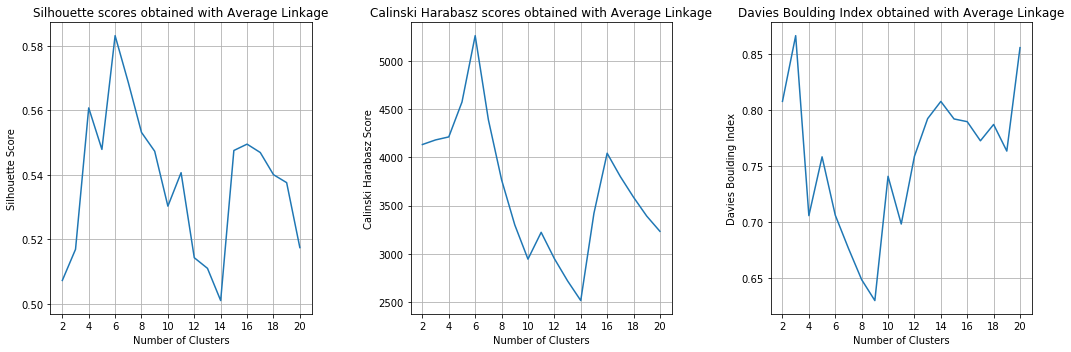

In [20]:
num_clusters=np.arange(2,21)
sil_scores, cb_scores, db_scores = plot_scores



f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax1.set_ylabel('Silhouette Score')
ax1.set_xticks(num_clusters[::2])
ax1.set_xticklabels(num_clusters[::2])

ax1.set_xlabel('Number of Clusters')
ax1.set_title('Silhouette scores obtained with Average Linkage')
ax1.grid()


ax2 = f.add_subplot(132)
ax2.set_ylabel('Calinski Harabasz Score')
ax2.set_xticks(num_clusters[::2])
ax2.set_xticklabels(num_clusters[::2])

ax2.set_xlabel('Number of Clusters')
ax2.set_title('Calinski Harabasz scores obtained with Average Linkage')
ax2.grid()


ax3 = f.add_subplot(133)
ax3.set_ylabel('Davies Boulding Index')
ax3.set_xticks(num_clusters[::2])
ax3.set_xticklabels(num_clusters[::2])

ax3.set_xlabel('Number of Clusters')
ax3.set_title('Davies Boulding Index obtained with Average Linkage')
ax3.grid()

plt.tight_layout()

plt1=ax1.plot(num_clusters, sil_scores)
plt2=ax2.plot(num_clusters, cb_scores)
plt3=ax3.plot(num_clusters, db_scores)


We notice that choosing 6 as the number of clusters with average linkage would maximize both the Silhouette and the Calinski Harabasz scores. As long as the Davies Boulding is concerned, even though at 6 it is not minimized, it performs discretely with respect to the other numbers of clusters computed.

In [21]:
best_k=6

### Graphical representation

Now that we chose the parameters we can perform the actual clustering and visualize the result.

In [22]:
#Final configuration
cluster = AgglomerativeClustering(n_clusters=best_k, affinity='euclidean', linkage='average')
pred=cluster.fit_predict(new_data)

In the graph below the number of elements per cluser is shown. The labels of the clusters are: "0","1","2","3","4","5"

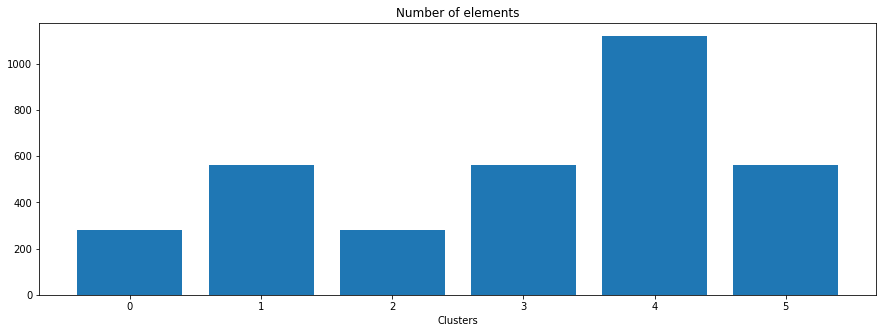

In [23]:
num_el=[] #List in which the k-th element will be the number of examples assigned to the kth cluster
for i in range(6):
    num_el.append(np.sum(pred==i))

f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot()
ax1.set_xlabel('Clusters')
ax1.set_title('Number of elements')
bar=ax1.bar(np.arange(6), num_el)


Let's now plot the clustered data over 2 (2D) and 3 (3D) principal components.

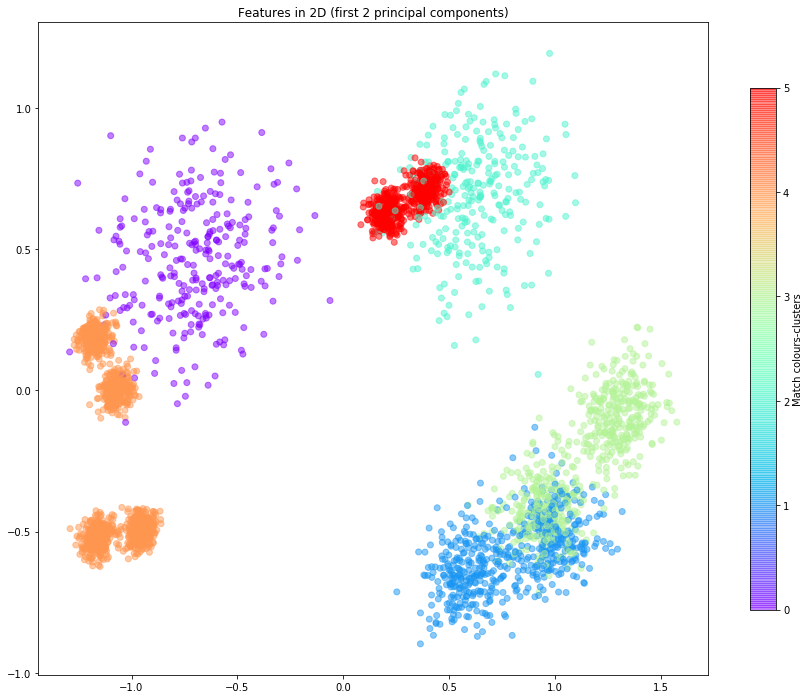

In [24]:
#2D
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot()  
ax.set_title('Features in 2D (first 2 principal components)')
scatt=ax.scatter(new_data[:,0],new_data[:,1],c=cluster.labels_, cmap='rainbow', alpha=0.5)
col_bar=plt.colorbar(scatt,shrink=0.8)
col_bar.set_label("Match colours-clusters")

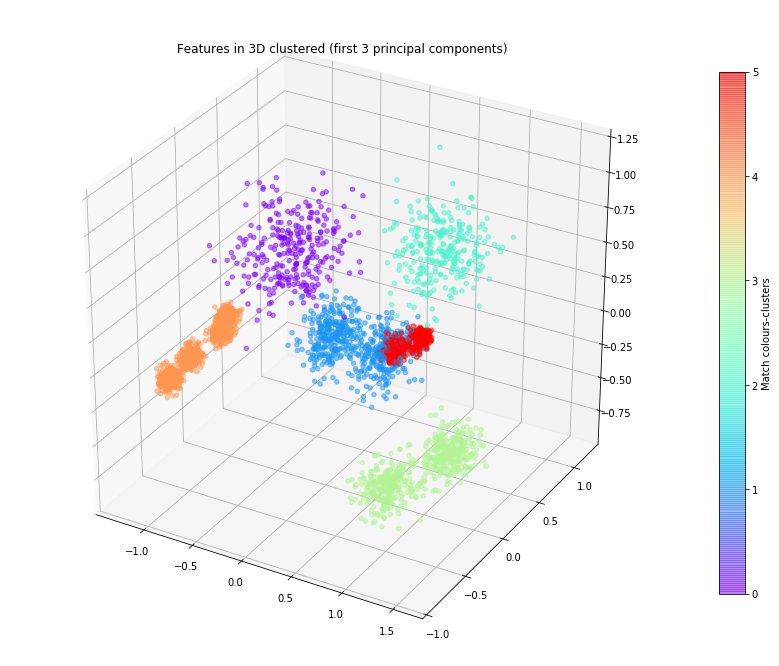

In [25]:
#3D
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection='3d')  
ax.set_title('Features in 3D clustered (first 3 principal components)')
scatt=ax.scatter(new_data[:,0],new_data[:,1], new_data[:,2],c=cluster.labels_, cmap='rainbow', alpha=0.5)
col_bar=plt.colorbar(scatt,shrink=0.8)
col_bar.set_label("Match colours-clusters")

### Dendrogram

When dealing with Hiherarchical clustering, a dendogram is a graph which allows a nice and simple visualisation of how the clusters are made.

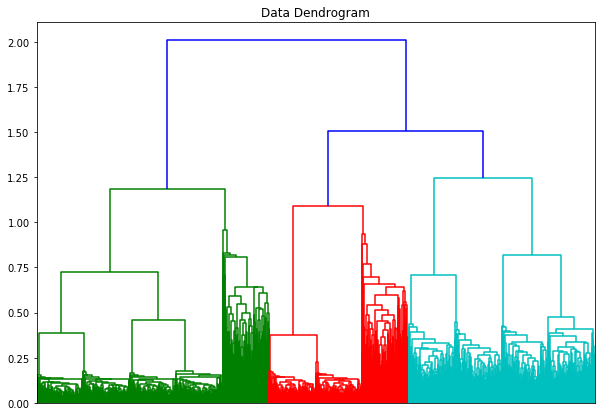

In [26]:
#I'm using here a Scipy method that performs Agglomerative Clustering to simplify the code for the Dendrogram.
#The actual clustering is quite similar to the one performed until now.
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Data Dendrogram")
dend = shc.dendrogram(shc.linkage(new_data, method='average'), no_labels=True)

## Conclusions

To sum up:
- Data were scaled through **MinMaxScaler**
- **PCA** was performed on the scaled data with 5 components to keep the 95% fo the variance
- **Euclidean affinity** was chosen
- **6** was found as an optimal number of clusters
- **Average Linkage** was the preferred linkage method.

Then, all the points were classified in such clusters.

We now print the cluster label of each element both here and in a text file. The labels corresponding to each cluster are: 0,1,2,3,4,5. 

In [27]:
cluster.labels_ 

array([5, 1, 2, ..., 2, 5, 0])

In [28]:
clustered_data= pd.DataFrame()
clustered_data["Cluster assigned"]=cluster.labels_
clustered_data.to_csv('Cluster_label.csv', sep=',', index=True)

In [29]:
print('The best number of clusters is', best_k)
clustered_data

The best number of clusters is 6


,Cluster assigned
0,5
1,1
2,2
3,4
4,4
...,...
3355,3
3356,3
3357,2
3358,5
